# Programming Assignment II: Explainability

In this assignment you will train machine learning models and experiment with techniques discussed in the lectures.
This assignment makes use of existing Python libraries. We have provided links to tutorials/examples if you're not familiar with them yet.


All code that you write should be in this notebook. You should submit:
* This notebook with your code added. Make sure to add enough documentation.
* A short report, max 3 pages including any figures and/or tables. Use this [template](https://www.overleaf.com/read/mvskntycrckw).
* Zip the notebook .ipynb and report .pdf files in a file with name format 'Prog_Explainability_Group_[X].zip', where X is your programming group ID (e.g. Prog_Explainability_Group_10.zip). The .ipynb and .pdf files should also have the same name as the zip file.


Important notes:
* Deadline for this assignment is **Monday June 7, 17:00**. 
* Send it to both Heysem Kaya (h.kaya@uu.nl) and Yupei Du (y.du@uu.nl), CCing your programming partner.
* Title of the email: [INFOMHCML] Explainability programming assignment submission [X], with X the number of your group.
* There will be a lab session to assist you with the assignment on **Tuesday, June 1, between 9:00-12:45 over Lab Channel in Teams**.



## Installation

For this assignment, we are going to use the following Python packages:

matplotlib, pandas, statsmodels, interpret, scikit-learn, openpyxl and graphviz

In [1]:
# Installing packages
!conda install python-graphviz
!pip install matplotlib pandas statsmodels interpret sklearn openpyxl

^C
^C


## Downloading the data
We are going to use the combined cycle power plant dataset. This dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. We have the following features: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). We will train ML models to predict the net hourly electrical energy output (EP) of the plant.

For a detailed description, see: [[Description](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant)]

We first need to download and prepare data. 


In [1]:
# Download and unzip data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
!unzip CCPP.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find or open CCPP.zip, CCPP.zip.zip or CCPP.zip.ZIP.


## Loading and preprocessing the data
We split the data into training (first 5000 instances) and validation (the subsequent 2000) and test (the last 2568) sets. We will use the training set to train a model, and validation set to optimize the model hyper-parameters. 


In [60]:
# Load and prepare data
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# global variables
DATA_FILENAME = 'CCPP/Folds5x2_pp.xlsx'
FEATURE_NAMES = ['AT', 'V', 'AP', 'RH']
LABEL_NAME = 'PE'
# Load the data from the excel file
def load_data():
    def split_feature_label(data_set):
        features = data_set[FEATURE_NAMES]
        labels = data_set[LABEL_NAME]
        return features, labels

    data = pd.read_excel(DATA_FILENAME)
    train_set, dev_set, test_set = data[:5000], data[5000: 7000], data[7000:]

    train_features, train_labels = split_feature_label(train_set)
    dev_features, dev_labels = split_feature_label(dev_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels


# preprocess (by z-normalization) the data for the regression task
# return the normalized feature sets and corresponding target variables 
def prepare_load_regression_data():
    train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = load_data()

    scaler = StandardScaler()
    scaler = scaler.fit(train_features)
    train_features = pd.DataFrame(data=scaler.transform(train_features), columns=FEATURE_NAMES)
    dev_features = pd.DataFrame(data=scaler.transform(dev_features), columns=FEATURE_NAMES)
    test_features = pd.DataFrame(data=scaler.transform(test_features), columns=FEATURE_NAMES)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels

# binarize the data for the classification task
# return the discretized feature sets and corresponding target variables 
def prepare_load_classification_data():
    train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = load_data()
    feature_mean, label_mean = train_features.mean(axis=0), train_labels.mean(axis=0)

    train_features = pd.DataFrame(data=np.where(train_features > feature_mean, 1, 0), columns=FEATURE_NAMES)
    dev_features = pd.DataFrame(data=np.where(dev_features > feature_mean, 1, 0), columns=FEATURE_NAMES)
    test_features = pd.DataFrame(data=np.where(test_features > feature_mean, 1, 0), columns=FEATURE_NAMES)
    train_labels = pd.DataFrame(data=np.where(train_labels > label_mean, 1, 0), columns=[LABEL_NAME])
    dev_labels = pd.DataFrame(data=np.where(dev_labels > label_mean, 1, 0), columns=[LABEL_NAME])
    test_labels = pd.DataFrame(data=np.where(test_labels > label_mean, 1, 0), columns=[LABEL_NAME])

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels

## Training and Interpreting a Linear Regression Model

**Q1**. Train a linear regression model (we recommend the statsmodels package) and report $R^2$ (goodness of fit) statistic. 

For model interpretability, provide for each feature (+ the bias variable) the following in tabular format: 
* Weight estimates
* SE (standard error of estimates) 
* T statistics 


Further Questions regarding the linear model (to be included in the report): 

**Q2**. Which three features are the most important?

**Q3**. How does the gas turbine energy yield (EP) change with unit (one degree C) increase of the ambient temperature given that all other feature values remain the same?

**Q4**. Visualize the weight estimates using 95% confidence intervals.

**Q5**. Show bar graph illustrations of the feature effects for the first two validation set instances.

In [93]:
train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = prepare_load_regression_data()


In [94]:
def calculate_mse_test_set(model_lr,params,X_test,test_labels):
    predictions = model_lr.predict(params,X_test)
    mse = np.mean(np.square(predictions-test_labels).values)
    return mse
    

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.644e+04
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        16:29:42   Log-Likelihood:                -14635.
No. Observations:                5000   AIC:                         2.928e+04
Df Residuals:                    4995   BIC:                         2.931e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.4443      0.064   7108.416      0.0

([<matplotlib.axis.YTick at 0x13d46300108>,
 [Text(0, 0, 'AT'), Text(0, 1, 'V'), Text(0, 2, 'AP'), Text(0, 3, 'RH')])

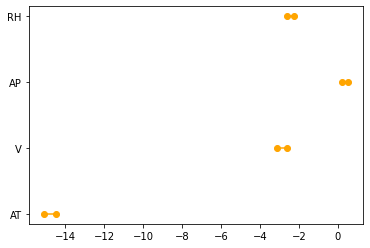

In [113]:
# We recommend the statsmodels package
import statsmodels.api as sm
import matplotlib.pyplot as plt

X_train = train_features.copy(deep=True)
X_test = test_features.copy(deep=True)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_lr = sm.OLS(train_labels, X_train)

res = model_lr.fit()

print(res.summary())
print("R2")
print(res.rsquared)
r2 = res.rsquared
print("Weight estimates")
print(res.params)
print("SE")
print(res.bse)
print("T-statistics")
print(res.tvalues)
print("Error of the model",res.mse_total)
feature_importance = []
test_mse = calculate_mse_test_set(model_lr,res.params,X_test,test_labels)

for feature in FEATURE_NAMES:
    augmented_test_set = test_features.copy(deep=True)
    augmented_test_set[feature] = augmented_test_set[feature].sample(frac=1).reset_index(drop=True)
    augmented_test_set = sm.add_constant(augmented_test_set)
    aug_test_mse = calculate_mse_test_set(model_lr,res.params,augmented_test_set,test_labels)
    feature_importance.append((feature,aug_test_mse/test_mse))
#     print(feature,'importance:',)
    
feature_importance = sorted(feature_importance,key=lambda x: x[1],reverse=True)
print("Important features with the most important being at the top")
for fi in feature_importance:
    print(fi[0],'\t',fi[1])

pred_list= []    
for aug in [0,1]:
    augmented_test_set = test_features.copy(deep=True)
    if aug:
        augmented_test_set['AT'] = augmented_test_set['AT']+1
    augmented_test_set = sm.add_constant(augmented_test_set)
    predictions = model_lr.predict(res.params,augmented_test_set)
    pred_list.append(predictions)
print("On AT 1 C increase EP increases by:",np.mean(pred_list[0]-pred_list[1]),"Probably not the right way to do this look into PDP + ICE")
ci = res.conf_int()

# plt.bar(confidence_intervals,100)
# plt.show()

data_dict = {}
data_dict['features'] = FEATURE_NAMES
data_dict['lower'] = ci[0].values[1:]
data_dict['upper'] = ci[1].values[1:]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['features']))

**Q6.** Reflection: why would training a regression tree not work well for this dataset?

## Training and Interpreting Classification Models
Using the preprocessing function implemented above to prepare the dataset for  the classification task. This function simply binarizes all variables including the target variable (EP) using the respective training set mean as threshold. A value of 1 means a high value vs 0 a low(er than average) value. Note that we do the feature binarization to ease interpretation of the models, normally that is not necessary for classification models.



### Training and Interpreting EBM
Train a Explainable Boosting Machine (with [interpret.ml](https://github.com/interpretml/interpret/))

For a tutorial see: [[Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Interpretable%20Classification%20Methods.ipynb)]

**Q7**. Report (global) feature importances for EBM as a table or figure. What are the most important three features in EBM? Are they the same as in the linear model? 


In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

# EBM

### Training and Explaining Neural Networks
Train two Neural Networks:
1. One-layer MLP (ReLU activation function + 50 hidden neurons)
2. Two-layer MLP (ReLU activation function + (20, 20) hidden neurons)

We recommend to use the Adam optimizer. Fine-tune the learning rate and any other hyper-parameters you find necessary. 

For a tutorial see: [[Tutorial](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)]

In [ ]:
from sklearn.neural_network import MLPClassifier

# One-layer MLP

# Two-layer MLP

You can check the tutorials for SHAP and LIME explanations for neural networks 
[[SHAP Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Explaining%20Blackbox%20Classifiers.ipynb)] 
[[LIME Tutorial](https://nbviewer.jupyter.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Explaining%20Blackbox%20Classifiers.ipynb)]


**Q8**. Provide explanations for randomly selected three test set instances using two explanation methods (LIME and SHAP) with two NN models  (namely the single-hidden layer NN model and the two-hidden-layer NN model: 2 x 2 x 3 = 12 explanations in total).

In [ ]:
# Global explanations
import graphviz
from interpret import show

# Local explanations (SHAP and LIME)
from interpret.blackbox import LimeTabular
from interpret.blackbox import ShapKernel